In [ ]:
# Import required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable

from tensorflow.keras.models import load_model

In [ ]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extracts the pathway directories to the test images and masks
test_image_dir = os.path.join("/path_to/test_image")
test_mask_dir = os.path.join("/path_to/test_mask")

# Get a list of image and mask file paths
test_image_paths = glob.glob(os.path.join(test_image_dir, '*.png'))
test_mask_paths = glob.glob(os.path.join(test_mask_dir, '*.png'))

# Sort the masks and images to make sure each pair corresponds to each other
test_image_paths = sorted(test_image_paths)
test_mask_paths = sorted(test_mask_paths)

# Checkpoint
print("test image", len(test_image_paths))
print("test mask", len(test_mask_paths))

test image 15
test mask 15


In [ ]:
# Define the function to load image and corresponding maks with tenseflow
def load_image_and_mask(image_path, mask_path):
    # Read the image path as binary data
    image = tf.io.read_file(image_path)
		# Decode the binary image data and specify 3 channels for coloured RGB image
    image = tf.io.decode_png(image,channels=3)
		# Read the corresponding mask path as binary data
    mask = tf.io.read_file(mask_path)
    # Decode the binary mask data and specify 1 channel for segmentation image
    mask = tf.io.decode_png(mask,channels=1)

		# Return a dictionary containing the image file name, image data, and segmentation mask data.
    return {'file_name': image_path, 'image': image, 'segmentation_mask': mask}

In [ ]:
# Define the image size
img_size = 256

In [ ]:
# Define RESIZE function
def resize(input_image, input_mask): # Takes image and corresponding mask as inputs
    # Resize the image with tf.resize
    input_image = tf.image.resize(input_image, (img_size, img_size), method="nearest")
    # Resize the mask with tf.resize
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")
    return input_image, input_mask


# Define NORMALIZE function
def normalize(input_image, input_mask): # Takes image and corresponding mask as inputs
   # Normalize input image to values 0-1
   input_image = tf.cast(input_image, tf.float32) / 255.0
   # Normalize input mask to values 0-1
   input_mask = tf.cast(input_mask, tf.float32) / 255
   return input_image, input_mask

In [ ]:
#TEST DATASET

# Load data
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_dataset = test_dataset.map(lambda image_path, mask_path: load_image_and_mask(image_path, mask_path))

# Resize
test_dataset = test_dataset.map(lambda x: resize(x["image"], x["segmentation_mask"]))
# Normalize
test_dataset = test_dataset.map(lambda x, y: normalize(x, y))

# Prepare test batches
test_batches = test_dataset.batch(1)

In [ ]:
# Define a function that creates a custom Adam optimizer
def custom_optimizer():
    return tf.keras.optimizers.Adam(
        learning_rate,  # Custom learning rate
        beta_1,           # Custom beta_1
        beta_2,         # Custom beta_2
        epsilon,         # Custom epsilon
    )

# Define loss function and store in keras class
@keras.saving.register_keras_serializable()
# Inherit class from tf.keras.losses.Loss
class DiceLoss(tf.keras.losses.Loss):
    # Initialise the loss function parameters
    def __init__(self, smooth=1, gama=2):
        super(DiceLoss, self).__init__()
        # Name loss function
        self.name = 'NDL'
        # Apply smoothing factor to avois division by zero
        self.smooth = smooth
        # Exponent valye for gama in denominator
        self.gama = gama

    # Call methds to compute the loss
    def call(self, y_true, y_pred):
        # Convert to float32
        y_true, y_pred = tf.cast(y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)

        # Numerator of the dice loss formula
        nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        # Denominator of the dice loss formulae
        denominator = tf.reduce_sum(y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        # Compute the final dice loss result
        result = 1 - tf.divide(nominator, denominator)
        return result

# Define dice coefficient metrics
def dice_coefficient_metric(y_true, y_pred, smooth=1):
    # Compute intersection between true and prediction values
    intersection = tf.reduce_sum(y_true * y_pred)
    # Compute denominator
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    # Compute dice coefficient
    dice_coefficient = (2.0 * intersection + smooth) / denominator
    return dice_coefficient

In [ ]:
# Load machine learning model
loaded_model = tf.keras.models.load_model("/path_to_ML_Model.model.keras",
                                       custom_objects={'DiceLoss': DiceLoss},
                                       compile = False)

In [ ]:
# Compile the model
unet_model.compile(
    optimizer=custom_optimizer(),# Use custom optimizer (here Adam)
    loss= DiceLoss(),  # Use custom loss function
    metrics=[dice_coefficient_metric])  # Use dice coefficient as a metric

NameError: ignored

1/1 [==============================] - 0s 28ms/step
Dice Score: 0.94842374


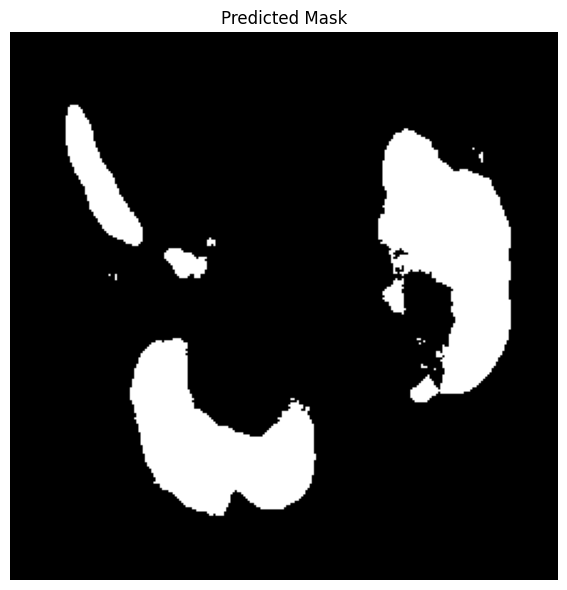

1/1 [==============================] - 0s 19ms/step
Dice Score: 0.66421103


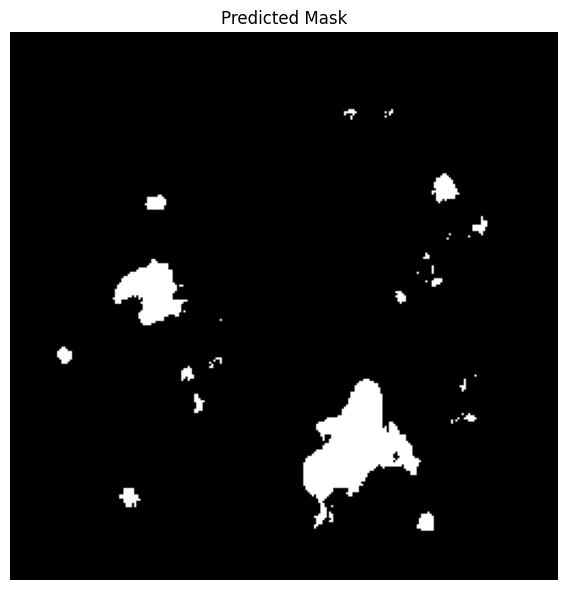

1/1 [==============================] - 0s 20ms/step
Dice Score: 0.9242864


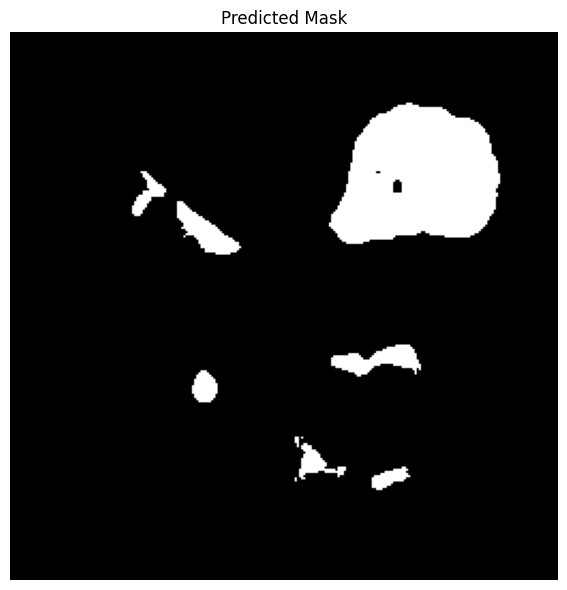

1/1 [==============================] - 0s 20ms/step
Dice Score: 0.8788852


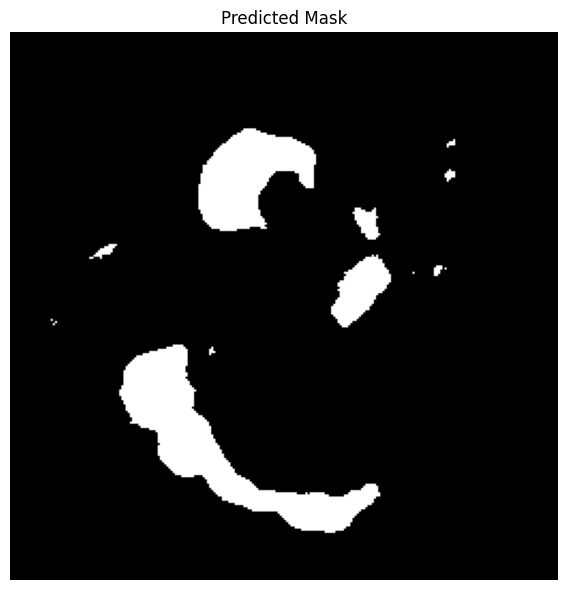

1/1 [==============================] - 0s 19ms/step
Dice Score: 0.80061215


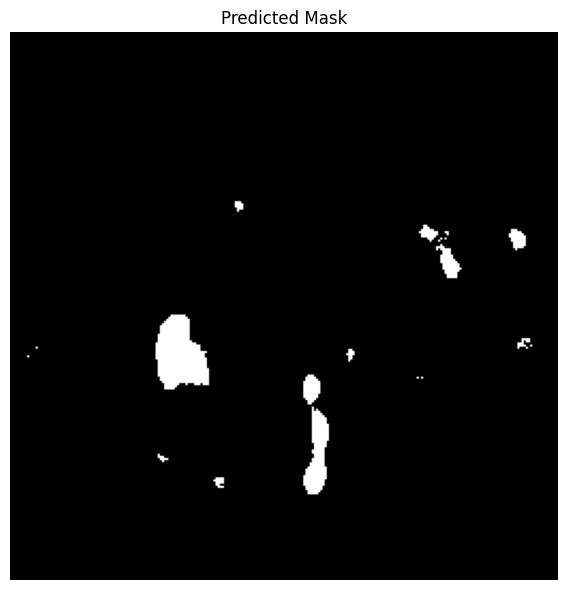

1/1 [==============================] - 0s 19ms/step
Dice Score: 0.72203344


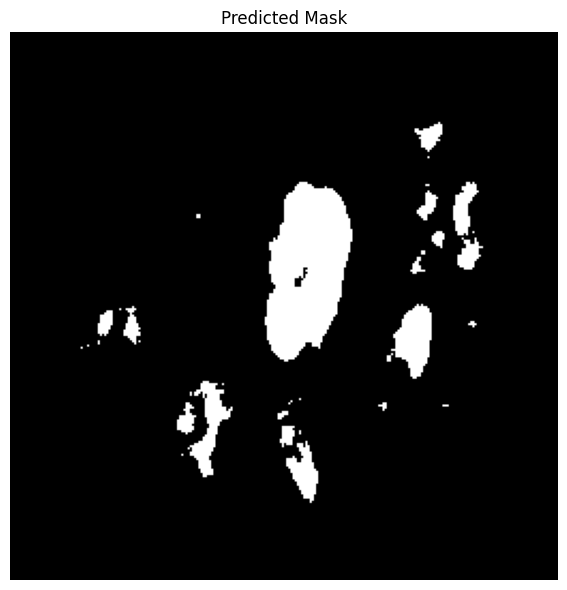

1/1 [==============================] - 0s 18ms/step
Dice Score: 0.9366653


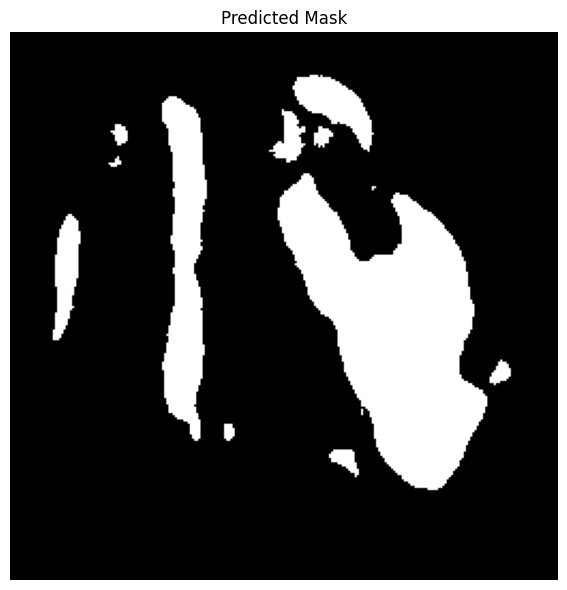

1/1 [==============================] - 0s 18ms/step
Dice Score: 0.91901195


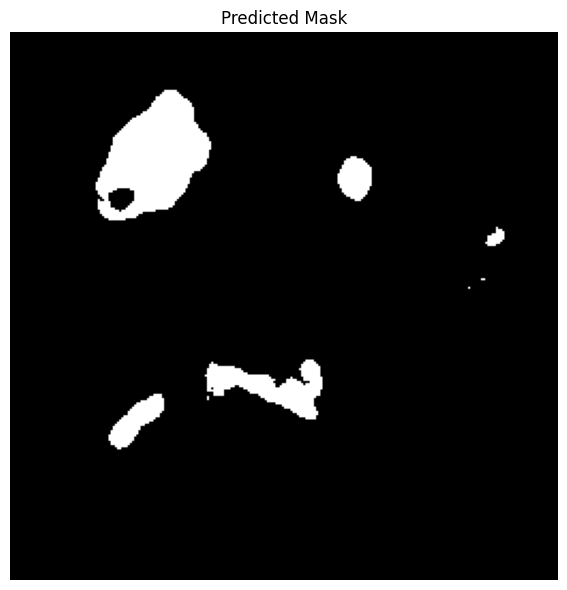

1/1 [==============================] - 0s 18ms/step
Dice Score: 0.86860245


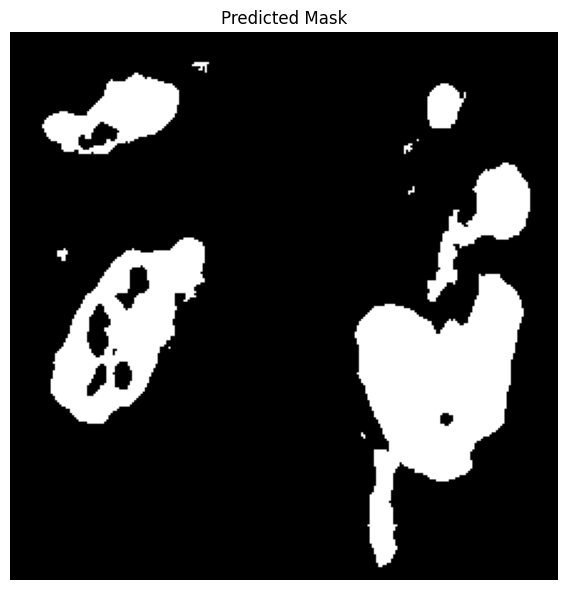

1/1 [==============================] - 0s 19ms/step
Dice Score: 0.8269307


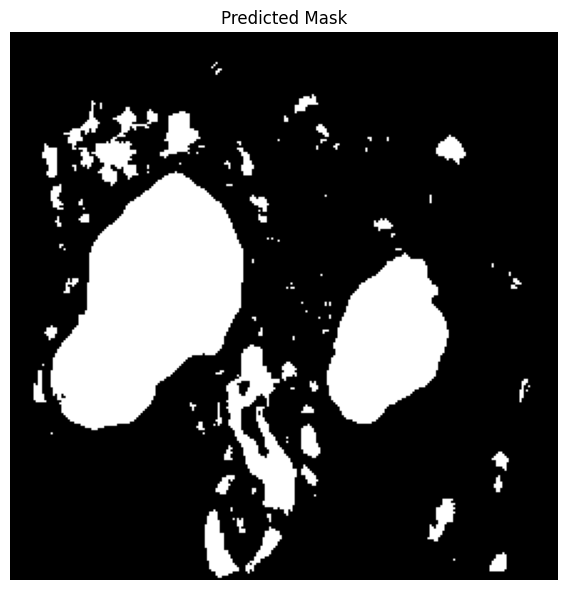

1/1 [==============================] - 0s 18ms/step
Dice Score: 0.95616436


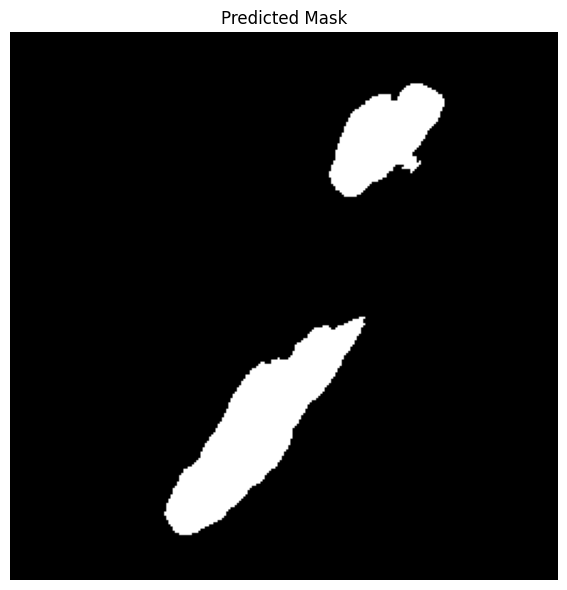

1/1 [==============================] - 0s 18ms/step
Dice Score: 0.95038015


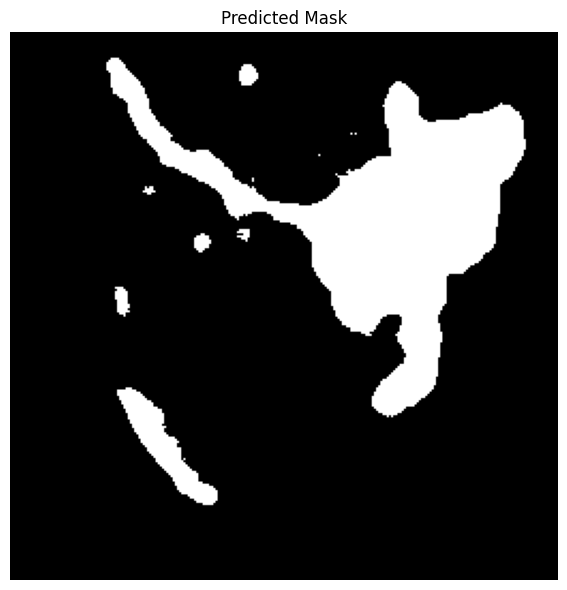

1/1 [==============================] - 0s 17ms/step
Dice Score: 0.93964654


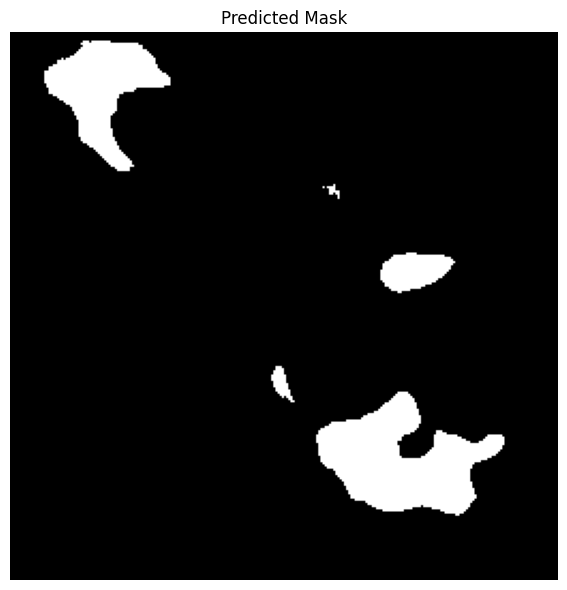

1/1 [==============================] - 0s 18ms/step
Dice Score: 0.7757668


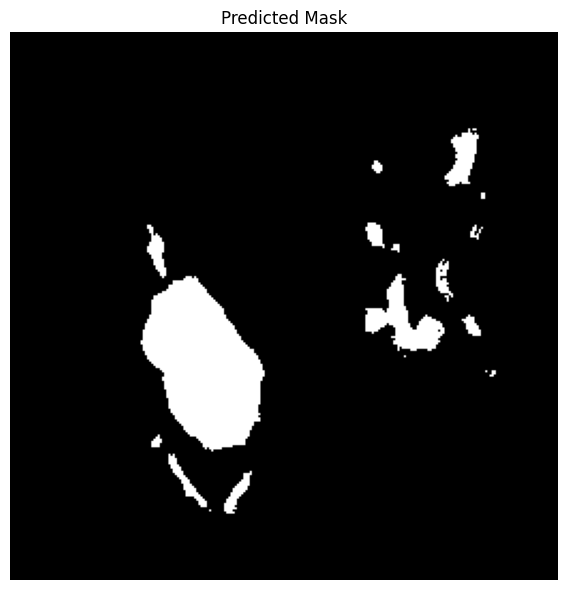

1/1 [==============================] - 0s 17ms/step
Dice Score: 0.771314


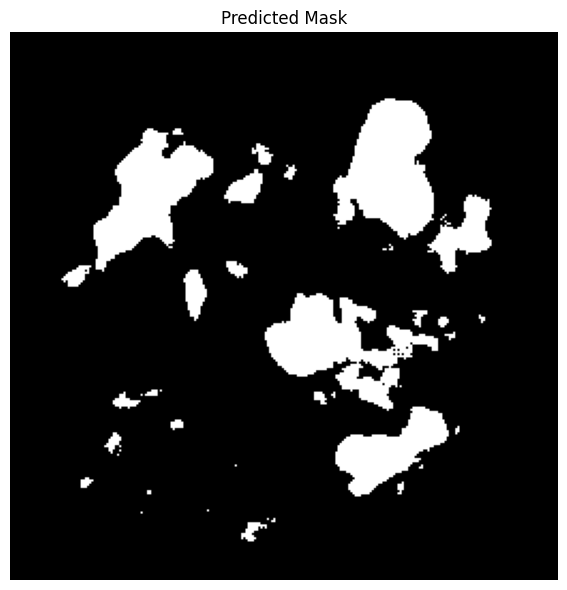

In [ ]:
#VIEW the predicton images and dice score for each sample

# Define function to create binary mask
def create_binary_mask(pred_masks):
    # Apply threshold to get binary mask
    binary_masks = tf.where(pred_masks > 0.9, 1.0, 0.0)
    return binary_masks

# Define function to display the predicted binary mask
def display_predicted_mask(predicted_mask):
    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Display the predicted mask
    ax.imshow(predicted_mask, cmap="gray")
    ax.set_title("Predicted Mask")
    ax.axis('off')

    plt.tight_layout()
    plt.show()


# Loop through the test image samples
for image, mask in test_batches:
    # Predict the masks using the loaded model
    probabilities = loaded_model.predict(image)

    # Get binary predictions
    predicted_mask = create_binary_mask(probabilities)

    # Ensure the same shape
    dice_score = dice_coefficient_metric(mask.numpy(), predicted_mask.numpy())

    # Print the dice score as numpy
    print("Dice Score:", dice_score.numpy())

    # Display the images with true and predicted masks
    display_predicted_mask(predicted_mask[0,:,:])

In [ ]:
# Save each prediction image to folder with cv2.imwrite

# Define function to create binary mask
def create_binary_mask(pred_masks):
    # Apply threshold to get binary mask
    binary_masks = tf.where(pred_masks > 0.9, 1.0, 0.0)
    return binary_masks


# Save each predicted mask as a PNG file
for i, (image, mask) in enumerate(test_batches):
    # Predict the masks using the loaded model
    probabilities = loaded_model.predict(image)

    # Get binary predictions
    binary_masks = create_binary_mask(probabilities)

    # Convert the predicted mask to a NumPy array before saving with cv2.imwrite()
    #predicted_mask_np = binary_masks[0].numpy()

    # Resize predicted mask to the original size of the input image
    original_size_mask = cv2.resize(binary_masks[0].numpy(), (image.shape[2], image.shape[1]))

    # Save the predicted mask as a PNG file using OpenCV
    #cv2.imwrite(f"/content/drive/MyDrive/DINA_KINGS/Year_3/Research_Project/Test_result/New_model/test_new_model_image_{i + 1}.png", (predicted_mask_np * 255).astype(np.uint8))
    cv2.imwrite(f"/content/drive/MyDrive/DINA_KINGS/Year_3/Research_Project/Test_result/New_model_256/test_ML_model_image_{i + 1}.png", (original_size_mask * 255).astype(np.uint8))



1/1 [==============================] - 10s 10s/step


NameError: ignored

Testing model images against test set

In [ ]:
#upload the images to pdf document

from matplotlib.backends.backend_pdf import PdfPages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/DINA_KINGS/Year_3/Research_Project/Trained_models/26_11_output_change_128_batch32_new_data.model.keras",
                                       custom_objects={'DiceLoss': DiceLoss},
                                       compile = False)
def create_binary_mask(pred_masks):
    # Apply threshold to get binary mask
    binary_masks = tf.where(pred_masks > 0.9, 1, 0)

    return tf.cast(binary_masks, tf.uint8)

# Create a PDF document to save all the figures
with PdfPages("pathway_to_document.pdf") as pdf:

    # Loop through test samples
    for image, mask in test_batches:
        # Predict the masks using the loaded model
        probabilities = loaded_model.predict(image)

        # Get binary predictions
        binary_masks = create_binary_mask(probabilities)

        # Display the images with true and predicted masks
        fig, axes = plt.subplots(1, 3, figsize=(10, 12))

        # Display the image
        axes[0].imshow(image[0, :, :, :])
        axes[0].set_title("Image")
        axes[0].axis('off')

        # Display the true mask
        axes[1].imshow(mask[0, :, :, 0], cmap='gray')
        axes[1].set_title("True Mask")
        axes[1].axis('off')

        # Display the predicted mask
        axes[2].imshow(binary_masks[0, :, :], cmap="gray")
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        plt.tight_layout()

        # Save the figure to the PDF document
        pdf.savefig()
        plt.close()


##Testing simple algorithm mask to test
Compare binary masks to ground truth and get dice score

In [ ]:
# Extract the pathway directory to mask
contour_mask_dir = os.path.join("/content/drive/MyDrive/DINA_KINGS/Year_3/Research_Project/HPC_data/simple_contour_algorithm_masked") # add directory

# Get a list of all mask file paths and save in list
contour_mask_paths = glob.glob(os.path.join(contour_mask_dir, '*.png'))

# Sort the masks in alphabetical order
contour_mask_paths = sorted(contour_mask_paths)

# Checkpoint
print("contour image", len(contour_mask_paths))

contour image 15


In [ ]:
# Define the function to load and read the mask
def load_mask(mask_path):
		#read the corresponding mask path as binary data
    mask = tf.io.read_file(mask_path)
    #decode the binary mask data and specify 1 channel for segmentation image
    mask = tf.io.decode_png(mask,channels=1)
		#Return a dictionary containing the image file name, image data, and segmentation mask data.
    return {'file_name': mask_path, 'segmentation_mask': mask}

#RESIZE
def resize_mask(input_mask):
    input_image = tf.image.resize(input_image, (img_size, img_size), method="nearest")
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")

    return input_image, input_mask


#NORMALIZE
def normalize_mask(input_mask):
   input_mask = tf.cast(input_mask, tf.float32) / 255
   return input_image, input_mask

In [ ]:
# Create a separate dataset for contour masks
contour_dataset = tf.data.Dataset.from_tensor_slices((contour_mask_paths))
contour_dataset = contour_dataset.map(lambda x: (x))  # Assuming your contour masks are in the same shape as segmentation masks

# Resize
contour_dataset = contour_dataset.map(lambda x: resize_mask(x["segmentation_mask"]))
# Normalize
contour_dataset = contour_dataset.map(lambda x: normalize_mask(x))

# Prepare contour batches
contour_batches = contour_dataset.batch(1)

TypeError: ignored

In [ ]:
# Define the function to load a mask
def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask, channels=1)
    return {'file_name': mask_path, 'segmentation_mask': mask}

# RESIZE mask
def resize_mask(data):
    input_mask = data['segmentation_mask']
    input_mask = tf.image.resize(input_mask, (img_size, img_size), method="nearest")
    data['segmentation_mask'] = input_mask
    return data

# NORMALIZE mask
def normalize_mask(data):
    input_mask = data['segmentation_mask']
    input_mask = tf.cast(input_mask, tf.float32) / 255
    data['segmentation_mask'] = input_mask
    return data

# Create a separate dataset for contour masks
contour_dataset = tf.data.Dataset.from_tensor_slices(contour_mask_paths)

# Load masks
contour_dataset = contour_dataset.map(lambda mask_path: load_mask(mask_path), num_parallel_calls=tf.data.AUTOTUNE)

# Resize
contour_dataset = contour_dataset.map(lambda x: resize_mask(x), num_parallel_calls=tf.data.AUTOTUNE)
# Normalize
contour_dataset = contour_dataset.map(lambda x: normalize_mask(x), num_parallel_calls=tf.data.AUTOTUNE)

# Prepare contour batches
contour_batches = contour_dataset.batch(1)

In [ ]:
# Define dice score metrics
def dice_coefficient_metric(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    dice_coefficient = (2.0 * intersection + smooth) / denominator
    return dice_coefficient

# Iterate over test batches and calculate Dice score
for (image, mask), contour_mask_data in zip(test_batches, contour_batches):
    contour_mask = contour_mask_data['segmentation_mask'].numpy()

    # Calculate Dice score
    dice_score = dice_coefficient_metric(mask.numpy(), contour_mask)
    print("Dice Score:", dice_score)


Dice Score: tf.Tensor(0.71921706, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.11693806, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.654526, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.418794, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.047066223, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.3149754, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.7079089, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.4808224, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.6282174, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.4749601, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.7513284, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.8305175, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.67002594, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.41472498, shape=(), dtype=float32)
Dice Score: tf.Tensor(0.40376294, shape=(), dtype=float32)


'\n    # Assuming predicted_masks is already defined\n    # Calculate Dice score for contour masks\n    contour_dice_score = dice_coefficient_metric(contour_mask, predicted_masks)\n    print("Contour Dice Score:", contour_dice_score)\n'